In [ ]:
import jax
import jax.numpy as jnp
from jax import config
import optax
import flax.linen as nn
config.update("jax_enable_x64", True)

from strfpy import *
from strfpy_jax import *
from model.frontend import *

In [25]:
class forwardSTRF(nn.Module):
  '''
  A forward model that takes in audio and outputs cortial features (STRFs).

  This class does not directly work with batch dimensions; use vmap to create
  a batch-compatible version.
  '''
#   update_lin: bool
#   pooling_stride: int = 3
#   use_class: bool = False

  def setup(self):
    self.audspec = AuditorySpectrogram(input_length=16000)

  def peripheral(self, x):
    return self.audspec(x).T # (Time, Freq)
    
  def __call__(self, x, params):
    # Peripheral step
    out = self.peripheral(x) # (Time, Freq)

    # Cortical step
    out = strf(out, params['sr']).real # (Channel, Time, Freq)
    #out = out.transpose(2, 1, 0) # (Freq, Time, Channel): channel-last
    return out

forwardModel = forwardSTRF()

cortical_params = {'sr': initialize_sr(40, 0, method='log')}
peripheral_params = forwardModel.init(jax.random.key(0), 
                           jnp.ones(16000), cortical_params)

In [33]:
# Test STMI

import librosa
from matplotlib import pyplot as plt

x, _ = librosa.load('./test.wav', sr=16000, offset = 0.5, duration=1.0)

(200, 129)


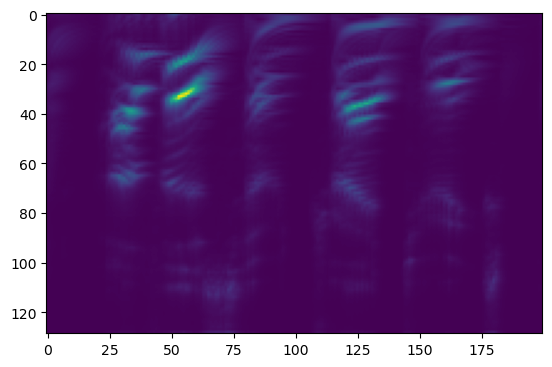

In [34]:
# Example: this obtains the auditory spectrogram (peripheral output)

y = forwardModel.apply(peripheral_params, x, method=forwardModel.peripheral)
print(y.shape)

plt.imshow(y.T)

In [21]:
x1 = np.concatenate([x[10:], np.zeros(10)])
print(x.shape, x1.shape)

(16000,) (16000,)


In [27]:
y = forwardModel.apply(peripheral_params, x, cortical_params)
y1 = forwardModel.apply(peripheral_params, x1, cortical_params)

In [32]:
jnp.sum(optax.losses.l2_loss(x1, x))

Array(89.95654368, dtype=float64)

In [ ]:
jnp.sum(optax.losses.l2_loss(y1, y))

Array(2.20633831, dtype=float64)